In [52]:
#this dataset will be used for prediction which team (red or blue) wins
#in a popular online multiplayer game: Legaue of Legends

#link to dataset:
#https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min?datasetId=600276&sortBy=voteCount

#starting PySpark session
from pyspark.sql import SparkSession

pyspark = SparkSession.builder.appName("League of Legends match outcome prediction").getOrCreate()

In [53]:
#create DataFrame
data_frame = pyspark.read.csv('high_diamond_ranked_10min.csv', header=True, inferSchema=True)

In [54]:
#read first row of the dataset
data_frame.head()

Row(gameId=4519157822, blueWins=0, blueWardsPlaced=28, blueWardsDestroyed=2, blueFirstBlood=1, blueKills=9, blueDeaths=6, blueAssists=11, blueEliteMonsters=0, blueDragons=0, blueHeralds=0, blueTowersDestroyed=0, blueTotalGold=17210, blueAvgLevel=6.6, blueTotalExperience=17039, blueTotalMinionsKilled=195, blueTotalJungleMinionsKilled=36, blueGoldDiff=643, blueExperienceDiff=-8, blueCSPerMin=19.5, blueGoldPerMin=1721.0, redWardsPlaced=15, redWardsDestroyed=6, redFirstBlood=0, redKills=6, redDeaths=9, redAssists=8, redEliteMonsters=0, redDragons=0, redHeralds=0, redTowersDestroyed=0, redTotalGold=16567, redAvgLevel=6.8, redTotalExperience=17047, redTotalMinionsKilled=197, redTotalJungleMinionsKilled=55, redGoldDiff=-643, redExperienceDiff=8, redCSPerMin=19.7, redGoldPerMin=1656.7)

In [55]:
#print all initial dataset columns and their interpreted types
data_frame.printSchema()

#blueWins is our target column for match outcome prediction

root
 |-- gameId: long (nullable = true)
 |-- blueWins: integer (nullable = true)
 |-- blueWardsPlaced: integer (nullable = true)
 |-- blueWardsDestroyed: integer (nullable = true)
 |-- blueFirstBlood: integer (nullable = true)
 |-- blueKills: integer (nullable = true)
 |-- blueDeaths: integer (nullable = true)
 |-- blueAssists: integer (nullable = true)
 |-- blueEliteMonsters: integer (nullable = true)
 |-- blueDragons: integer (nullable = true)
 |-- blueHeralds: integer (nullable = true)
 |-- blueTowersDestroyed: integer (nullable = true)
 |-- blueTotalGold: integer (nullable = true)
 |-- blueAvgLevel: double (nullable = true)
 |-- blueTotalExperience: integer (nullable = true)
 |-- blueTotalMinionsKilled: integer (nullable = true)
 |-- blueTotalJungleMinionsKilled: integer (nullable = true)
 |-- blueGoldDiff: integer (nullable = true)
 |-- blueExperienceDiff: integer (nullable = true)
 |-- blueCSPerMin: double (nullable = true)
 |-- blueGoldPerMin: double (nullable = true)
 |-- redW

In [56]:
#count how many rows and columns the dataset has
rows = data_frame.count()
cols = len(data_frame.columns)

print("Number of rows: ", rows)
print("Number of columns: ", cols)

Number of rows:  9879
Number of columns:  40


In [57]:
#remove gameId column
data_frame = data_frame.drop('gameId')
cols = len(data_frame.columns)
print("Number of columns: ", cols)

Number of columns:  39


In [58]:
#select certain columns and print them (DataFrame API)
data_frame.select('blueKills', 'blueDeaths', 'blueAssists', 'redKills', 'redDeaths', 'redAssists').show(10)

+---------+----------+-----------+--------+---------+----------+
|blueKills|blueDeaths|blueAssists|redKills|redDeaths|redAssists|
+---------+----------+-----------+--------+---------+----------+
|        9|         6|         11|       6|        9|         8|
|        5|         5|          5|       5|        5|         2|
|        7|        11|          4|      11|        7|        14|
|        4|         5|          5|       5|        4|        10|
|        6|         6|          6|       6|        6|         7|
|        5|         3|          6|       3|        5|         2|
|        7|         6|          7|       6|        7|         9|
|        5|        13|          3|      13|        5|        11|
|        7|         7|          8|       7|        7|         5|
|        4|         5|          5|       5|        4|         4|
+---------+----------+-----------+--------+---------+----------+
only showing top 10 rows



In [59]:
#select same columns as above using SQL

#create SQL table
sql_table = pyspark.read.option("header", True) \
          .csv("high_diamond_ranked_10min.csv") \
          .createOrReplaceTempView("lolDiamondGames")

#SQL selecting from a created table
pyspark.sql("SELECT blueKills, blueDeaths, blueAssists, redKills, redDeaths, redAssists FROM lolDiamondGames").show(10)

+---------+----------+-----------+--------+---------+----------+
|blueKills|blueDeaths|blueAssists|redKills|redDeaths|redAssists|
+---------+----------+-----------+--------+---------+----------+
|        9|         6|         11|       6|        9|         8|
|        5|         5|          5|       5|        5|         2|
|        7|        11|          4|      11|        7|        14|
|        4|         5|          5|       5|        4|        10|
|        6|         6|          6|       6|        6|         7|
|        5|         3|          6|       3|        5|         2|
|        7|         6|          7|       6|        7|         9|
|        5|        13|          3|      13|        5|        11|
|        7|         7|          8|       7|        7|         5|
|        4|         5|          5|       5|        4|         4|
+---------+----------+-----------+--------+---------+----------+
only showing top 10 rows



In [60]:
#calculate KDA for each team per game: KDA = (kills + assists) / deaths
from pyspark.sql.functions import round

data_frame = data_frame.withColumn('blueKda',
                                   round((data_frame.blueKills + data_frame.blueAssists) / data_frame.blueDeaths , 2))
data_frame = data_frame.withColumn('redKda',
                                   round((data_frame.redKills + data_frame.redAssists) / data_frame.redDeaths , 2))
data_frame.select(['blueKda', 'redKda']).show(10)

+-------+------+
|blueKda|redKda|
+-------+------+
|   3.33|  1.56|
|    2.0|   1.4|
|    1.0|  3.57|
|    1.8|  3.75|
|    2.0|  2.17|
|   3.67|   1.0|
|   2.33|  2.14|
|   0.62|   4.8|
|   2.14|  1.71|
|    1.8|  2.25|
+-------+------+
only showing top 10 rows



In [61]:
#current number of columns in dataset
cols = len(data_frame.columns)
print("DataFrame columns count :", cols)

DataFrame columns count : 41


In [62]:
#cleaning dataset
#count number of NA rows before cleaning
print( "Number of rows with NA value: ", data_frame.subtract( data_frame.dropna() ).count() )

Number of rows with NA value:  135


In [63]:
#replacing NA rows with a mean value
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=data_frame.columns, 
    outputCols=[c.format(c) for c in data_frame.columns]
    ).setStrategy("mean")

# Add imputation cols to dataframe
data_frame = imputer.fit(data_frame).transform(data_frame)

#count number of NA rows after transforming them into mean values
print( "Number of rows with NA values: ", data_frame.subtract( data_frame.dropna() ).count() )

Number of rows with NA values:  0


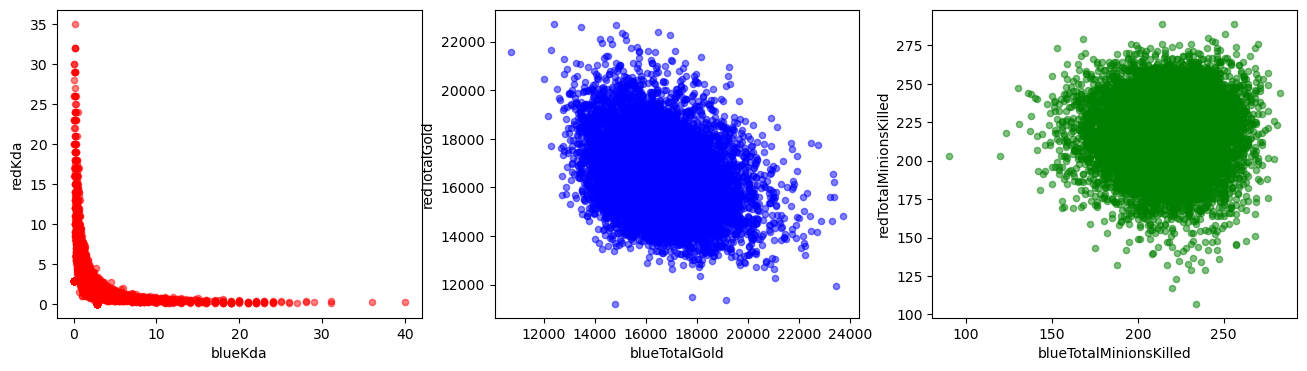

In [64]:
#multiple plots to compare red and blue team stats using Pandas and Matplotlib
import pandas as pd
import matplotlib.pyplot as plt

data_frame_pd = data_frame.toPandas()

fig, ax = plt.subplots(ncols=3, figsize=(16,4))

data_frame_pd.plot.scatter(x='blueKda', y='redKda', c='red', alpha=0.5, ax=ax[0])
data_frame_pd.plot.scatter(x='blueTotalGold', y='redTotalGold', c='blue', alpha=0.5, ax=ax[1])
data_frame_pd.plot.scatter(x='blueTotalMinionsKilled', y='redTotalMinionsKilled', c='green', alpha=0.5, ax=ax[2])

plt.show()

In [65]:
#combining values of each column in a single vector using VectorAssembler
from pyspark.ml.feature import VectorAssembler

numeric_cols = [c for c in data_frame.columns if c not in ['blueWins']]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
data_frame = assembler.transform(data_frame)

data_frame.select('features').show(10)

+--------------------+
|            features|
+--------------------+
|[28.0,2.0,1.0,9.0...|
|[12.0,1.0,0.0,5.0...|
|[15.0,0.0,0.0,7.0...|
|[43.0,1.0,0.0,4.0...|
|[75.0,4.0,0.0,6.0...|
|[18.0,0.0,0.0,5.0...|
|[18.0,3.0,1.0,7.0...|
|[16.0,2.0,0.0,5.0...|
|[16.0,3.0,0.0,7.0...|
|[13.0,1.0,1.0,4.0...|
+--------------------+
only showing top 10 rows



In [66]:
#Normalization
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="features_normalized")
data_frame = scaler.fit(data_frame).transform(data_frame)
data_frame.select(['features', 'features_normalized']).show(10)

+--------------------+--------------------+
|            features| features_normalized|
+--------------------+--------------------+
|[28.0,2.0,1.0,9.0...|[1.55390008946549...|
|[12.0,1.0,0.0,5.0...|[0.66595718119949...|
|[15.0,0.0,0.0,7.0...|[0.83244647649937...|
|[43.0,1.0,0.0,4.0...|[2.38634656596486...|
|[75.0,4.0,0.0,6.0...|[4.16223238249685...|
|[18.0,0.0,0.0,5.0...|[0.99893577179924...|
|[18.0,3.0,1.0,7.0...|[0.99893577179924...|
|[16.0,2.0,0.0,5.0...|[0.88794290826599...|
|[16.0,3.0,0.0,7.0...|[0.88794290826599...|
|[13.0,1.0,1.0,4.0...|[0.72145361296612...|
+--------------------+--------------------+
only showing top 10 rows



In [67]:
#Correlation matrix
from pyspark.ml.stat import Correlation
matrix = Correlation.corr(data_frame, 'features_normalized').collect()[0][0]
corr_matrix = matrix.toArray().tolist()
print(corr_matrix)

[[1.0, 0.03444722001301317, 0.003228265854735615, 0.01813845286350808, -0.00261216273824159, 0.03321650282728413, 0.01989166145591634, 0.017676232818277047, 0.010103642633885652, 0.009461756299750107, 0.019724619122304145, 0.034348848021210306, 0.03171895847458744, -0.03392468712685751, 0.01050071652570813, 0.015799805858957364, 0.027942986051619757, -0.033924687126857526, 0.019724619122304107, -0.012905646327433068, 0.11554894429120299, -0.003228265854735651, -0.00261216273824159, 0.01813845286350808, -0.00900945375825949, -0.022816761772644883, -0.02012061321583624, -0.011963690704796644, -0.008224531119615942, -0.0056854293200946674, -0.008882415825217005, -0.012999941666618439, -0.012394858434986973, 0.0012237813233275019, -0.015799805858957364, -0.027942986051619757, -0.01239485843498691, -0.0056854293200946605, 0.00743423120031391, -0.015678691985625468], [0.03444722001301317, 1.0, 0.017716598446153135, 0.0337480748815397, -0.07318248286832567, 0.06779332162883474, 0.041700463105

C:\Users\Jovana\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [68]:
#show correlation matrix using pandas
corr_matrix_ps = data_frame_pd.corr()
corr_matrix_ps.style.background_gradient(cmap='coolwarm')

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueKda,redKda
blueWins,1.000000,0.000087,0.044247,0.201769,0.337358,-0.339297,0.276685,0.221944,0.213768,0.092385,0.115566,0.417213,0.357820,0.396141,0.224909,0.131445,0.511119,0.489558,0.224909,0.417213,-0.023671,-0.055400,-0.201769,-0.339297,0.337358,-0.271047,-0.221551,-0.209516,-0.097172,-0.103696,-0.411396,-0.352127,-0.387588,-0.212171,-0.110994,-0.511119,-0.489558,-0.212171,-0.411396,0.351760,-0.349813
blueWardsPlaced,0.000087,1.000000,0.034447,0.003228,0.018138,-0.002612,0.033217,0.019892,0.017676,0.010104,0.009462,0.019725,0.034349,0.031719,-0.033925,0.010501,0.015800,0.027943,-0.033925,0.019725,-0.012906,0.115549,-0.003228,-0.002612,0.018138,-0.009009,-0.022817,-0.020121,-0.011964,-0.008225,-0.005685,-0.008882,-0.013000,-0.012395,0.001224,-0.015800,-0.027943,-0.012395,-0.005685,0.007434,-0.015679
blueWardsDestroyed,0.044247,0.034447,1.000000,0.017717,0.033748,-0.073182,0.067793,0.041700,0.040504,0.016940,-0.009150,0.060054,0.060294,0.067462,0.111028,-0.023452,0.078585,0.077946,0.111028,0.060054,0.135966,0.123919,-0.017717,-0.073182,0.033748,-0.046212,-0.034509,-0.034439,-0.012712,-0.023943,-0.067467,-0.059090,-0.057314,0.040023,-0.035732,-0.078585,-0.077946,0.040023,-0.067467,0.062031,-0.067505
blueFirstBlood,0.201769,0.003228,0.017717,1.000000,0.269425,-0.247929,0.229485,0.151603,0.134309,0.077509,0.083316,0.312058,0.177617,0.190365,0.125642,0.018190,0.378511,0.240665,0.125642,0.312058,-0.019142,-0.043304,-1.000000,-0.247929,0.269425,-0.201140,-0.141627,-0.135327,-0.060246,-0.069584,-0.301479,-0.182602,-0.194920,-0.156711,-0.024559,-0.378511,-0.240665,-0.156711,-0.301479,0.283079,-0.290650
blueKills,0.337358,0.018138,0.033748,0.269425,1.000000,0.004044,0.813667,0.178540,0.170436,0.076195,0.180314,0.888751,0.434867,0.472155,-0.030880,-0.112506,0.654148,0.583730,-0.030880,0.888751,-0.034239,-0.092278,-0.269425,0.004044,1.000000,-0.020344,-0.224564,-0.207949,-0.104423,-0.082491,-0.161127,-0.412219,-0.462333,-0.472203,-0.214454,-0.654148,-0.583730,-0.472203,-0.161127,0.476464,-0.552844
blueDeaths,-0.339297,-0.002612,-0.073182,-0.247929,0.004044,1.000000,-0.026372,-0.204764,-0.188852,-0.095527,-0.071441,-0.162572,-0.414755,-0.460122,-0.468560,-0.228102,-0.640000,-0.577613,-0.468560,-0.162572,0.008102,0.038672,0.247929,1.000000,0.004044,0.804023,0.163340,0.150746,0.076639,0.156780,0.885728,0.433383,0.464584,-0.040521,-0.100271,0.640000,0.577613,-0.040521,0.885728,-0.551687,0.465137
blueAssists,0.276685,0.033217,0.067793,0.229485,0.813667,-0.026372,1.000000,0.149043,0.170873,0.028434,0.123663,0.748352,0.292661,0.303022,-0.062035,-0.134023,0.549761,0.437002,-0.062035,0.748352,-0.032474,-0.064501,-0.229485,-0.026372,0.813667,-0.007481,-0.182985,-0.189563,-0.058074,-0.060880,-0.133948,-0.356928,-0.396652,-0.337515,-0.160915,-0.549761,-0.437002,-0.337515,-0.133948,0.514592,-0.454128
blueEliteMonsters,0.221944,0.019892,0.041700,0.151603,0.178540,-0.204764,0.149043,1.000000,0.781039,0.640271,0.166644,0.239396,0.203530,0.232774,0.118762,0.198378,0.281464,0.263991,0.118762,0.239396,-0.017292,-0.005288,-0.151603,-0.204764,0.178540,-0.156764,-0.455139,-0.471754,-0.144104,-0.052029,-0.216616,-0.169649,-0.189816,-0.074838,-0.087893,-0.281464,-0.263991,-0.074838,-0.216616,0.198850,-0.198516
blueDragons,0.213768,0.017676,0.040504,0.134309,0.170436,-0.188852,0.170873,0.781039,1.000000,0.020381,0.039750,0.186413,0.160683,0.179083,0.086686,0.159595,0.2

In [73]:
#reduce dimensions using PCA (Principal Component Analysis) learning algorithm
from pyspark.ml.feature import PCA
pca = PCA(k=18, inputCol="features_normalized", outputCol="pca_features")
model_pca = pca.fit(data_frame)

#Cumulative Proportion of Variance
sum(model_pca.explainedVariance)

0.9544181617390758

In [74]:
result_pca = model_pca.transform(data_frame).select("pca_features")
result_pca.show(1, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [75]:
#using Random Forest Algorithm to predict which team will win the game (0 = redWins, 1 = blueWins)
from pyspark.ml.classification import RandomForestClassifier

#split the data into training and test sets (70% is used for training and 30% for testing)
(train, test) = data_frame.randomSplit([0.7, 0.3])

#print how many rows are used for training and test
print("Rows used for training: ", train.count())
print("Rows used for testing: ", test.count())

#train a RandomForest model
rf = RandomForestClassifier(featuresCol="features_normalized", labelCol='blueWins', numTrees=10)

#train model
model = rf.fit(train)

#make predictions
predictions = model.transform(test)

data_frame.select('blueWins').show(10)
predictions.select('prediction').show(10)

Rows used for training:  6884
Rows used for testing:  2995
+--------+
|blueWins|
+--------+
|       0|
|       0|
|       0|
|       0|
|       0|
|       1|
|       1|
|       0|
|       0|
|       1|
+--------+
only showing top 10 rows

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
+----------+
only showing top 10 rows



In [76]:
#evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='blueWins', predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: ", accuracy * 100, "%")
print("Test Error: ", (1.0 - accuracy) * 100, "%")

Accuracy:  72.0845707787932 %
Test Error:  27.91542922120679 %
